<a href="https://colab.research.google.com/github/RajatRasal/Gaussian-Process-Dynamical-Model/blob/main/experiments/Gaussian_Process_Latent_Variable_Model_for_Dynamical_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

# Gaussian Process Latent Variable Models

## Imports

In [1]:
!git clone https://github.com/RajatRasal/Gaussian-Process-Dynamical-Model.git

fatal: destination path 'Gaussian-Process-Dynamical-Model' already exists and is not an empty directory.


In [2]:
!pip install transforms3d

In [3]:
import sys
sys.path.append('Gaussian-Process-Dynamical-Model')

import numpy as np
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
from sklearn.decomposition import PCA
%pylab inline

from dataloader import amc_to_matrix

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
np_precision = np.float64

Populating the interactive namespace from numpy and matplotlib


## Load MNIST Data

In [4]:
!wget http://mocap.cs.cmu.edu/subjects/07/07_02.amc

--2022-04-17 10:19:22--  http://mocap.cs.cmu.edu/subjects/07/07_02.amc
Resolving mocap.cs.cmu.edu (mocap.cs.cmu.edu)... 128.2.220.105
Connecting to mocap.cs.cmu.edu (mocap.cs.cmu.edu)|128.2.220.105|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 263117 (257K)
Saving to: ‘07_02.amc.7’

07_02.amc.7         100%[===================>] 256.95K  1.40MB/s    in 0.2s    

2022-04-17 10:19:22 (1.40 MB/s) - ‘07_02.amc.7’ saved [263117/263117]



In [5]:
x = amc_to_matrix('./07_02.amc')
small_x_train = np.array(x, dtype=np_precision)
small_x_train -= small_x_train.mean(axis=0)
N = small_x_train.shape[0]
dim = small_x_train.shape[1]

In [6]:
tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[0], 'GPU')

## Prepare trainable variables
We'll be jointly training 3 model parameters as well as the latent inputs.

In [24]:
# Create some trainable model parameters. We will constrain them to be strictly
# positive when constructing the kernel and the GP.
unconstrained_amplitude = tf.Variable(np_precision(1.), name='amplitude')
unconstrained_length_scale = tf.Variable(np_precision(1.), name='length_scale')
unconstrained_slope_variance = tf.Variable(np_precision(1.), name='slope_variance')
unconstrained_observation_noise_var = tf.Variable(
    np.random.normal(size=(dim, 1)).astype(dtype=np_precision),
    name='obs_noise',
)

# We need to flatten the images and, somewhat unintuitively, transpose from
# shape [100, 784] to [784, 100]. This is because the 784 pixels will be
# treated as *independent* conditioned on the latent inputs, meaning we really
# have a batch of 784 GP's with 100 index_points.
observations_ = small_x_train.reshape(N, -1).transpose()

# Create a collection of N 2-dimensional index points that will represent our
# latent embeddings of the data. (Lawrence, 2004) prescribes initializing these
# with PCA, but a random initialization actually gives not-too-bad results, so
# we use this for simplicity. For a fun exercise, try doing the
# PCA-initialization yourself!
latent_dims = 3
latent_init = 'pca'
if latent_init == 'random':
    init_ = np.random.normal(size=(N, latent_dims)) \
        .astype(dtype=np_precision)
elif latent_init == 'pca':
    init_ = PCA(n_components=latent_dims) \
        .fit_transform(small_x_train) \
        .astype(dtype=np_precision)
latent_index_points = tf.Variable(init_, name='latent_index_points')

## Construct model and training ops

In [25]:
def constrain_positive(unconstrained_var):
    EPS = np.finfo(np_precision).eps
    return tf.math.softplus(EPS + unconstrained_var)

def create_kernel(
    unconstrained_amplitude,
    unconstrained_length_scale,
    unconstrained_slope_variance,
):
    amplitude = constrain_positive(unconstrained_amplitude)
    length_scale = constrain_positive(unconstrained_length_scale)
    rbf_kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale)
    linear_kernel = tfk.Linear(slope_variance=unconstrained_slope_variance)
    return rbf_kernel + linear_kernel

def build_gp(**gp_params):
    return tfd.GaussianProcessRegressionModel(**gp_params)

def loss_fn(
    obs,
    unconstrained_amplitude,
    unconstrained_length_scale,
    unconstrained_slope_variance,
    unconstrained_observation_noise_var,
    latent_index_points,
):
    observation_noise_variance = constrain_positive(
        unconstrained_observation_noise_var
    )
    kernel = create_kernel(
        unconstrained_amplitude,
        unconstrained_length_scale,
        unconstrained_slope_variance,
    )
    gp = build_gp(
        kernel=kernel,
        index_points=latent_index_points,
        observation_noise_variance=observation_noise_variance,
    )
    log_probs = gp.log_prob(obs, name='log_prob')
    return -tf.reduce_mean(log_probs)

@tf.function(autograph=False, jit_compile=True)
def train_model():
    LR = 0.1
    optimizer = tf.optimizers.Adam(learning_rate=LR)
    
    trainable_variables = [
        unconstrained_amplitude,
        unconstrained_length_scale,
        unconstrained_slope_variance,
        unconstrained_observation_noise_var,
        latent_index_points
    ]
    with tf.GradientTape() as tape:
        loss_value = loss_fn(observations_, *trainable_variables)
    grads = tape.gradient(loss_value, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    return loss_value

## Train and plot the resulting latent embeddings

In [26]:
# Initialize variables and train!
num_iters = 1000
log_interval = 100
for i in range(num_iters):
    loss = train_model()
    if i % log_interval == 0 or i + 1 == num_iters:
        print("Loss at step %d: %f" % (i, loss))

Loss at step 0: 1354.029577
Loss at step 100: 429.181446
Loss at step 200: 371.201398
Loss at step 300: 343.096957
Loss at step 400: 326.880079
Loss at step 500: 315.821993
Loss at step 600: 308.892548
Loss at step 700: 304.481210
Loss at step 800: 300.920599
Loss at step 900: 298.804597
Loss at step 999: 296.270027


## Plot results

In [29]:
def plotting_latent_2d(before, after):
    plt.figure(figsize=(7, 7))
    plt.title("Before training")
    plt.grid(False)
    plt.scatter(
        x=before[:, 0],
        y=before[:, 1],
        color='green',
        s=50
    )
    plt.show()

    plt.figure(figsize=(7, 7))
    plt.title("After training")
    plt.grid(False)
    plt.scatter(
        x=after[:, 0],
        y=after[:, 1],
        color='blue',
        s=50
    )
    plt.show()

def plotting_latent_3d(before, after):
    plt.figure(figsize=(7, 7))
    ax = plt.axes(projection='3d')
    ax.set_title("Before training")
    ax.scatter3D(
        before[:, 0],
        before[:, 1],
        before[:, 2],
        color='green',
        # s=50
    )
    plt.show()
    
    plt.figure(figsize=(7, 7))
    ax = plt.axes(projection='3d')
    ax.set_title("After training")
    ax.scatter3D(
        after[:, 0],
        after[:, 1],
        after[:, 2],
        color='blue',
        # s=50
    )
    plt.show()

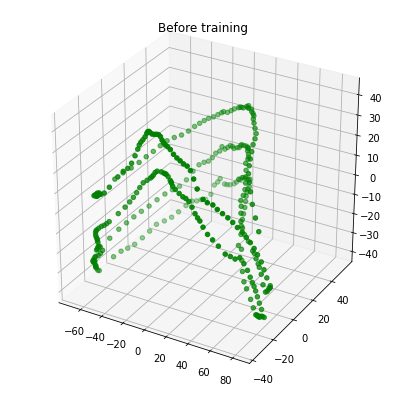

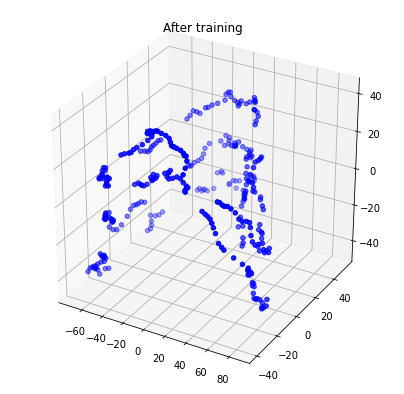

In [30]:
# Plot the latent locations before and after training
if latent_dims == 2:
    plotting_latent_2d(init_, latent_index_points.numpy())
elif latent_dims == 3:
    plotting_latent_3d(init_, latent_index_points.numpy())
else:
    pass

## Construct predictive model and sampling ops

In [ ]:
gprm = build_gp(
    kernel=kernel,
    index_points=latent_index_points,
    observation_index_points=latent_index_points,
    observations=observations_,
)

samples = gprm.sample()

# Plot the grid of samples at new points. We do a bit of tweaking of the samples
# first, squeezing off extra 1-shapes and normalizing the values.